<a href="https://colab.research.google.com/github/gabrielppierre/ET586_Fraud_Bayes/blob/main/projeto_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importando as bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### conectando ao google drive e carregando o conjunto de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/ET586_seminario/dataset/creditcard.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Analisando o dataset

In [ ]:
print(data.head())
print("\nDimensões do conjunto de dados:", data.shape)
print("\nTipos de dados:\n", data.dtypes)
print("\nEstatísticas descritivas:\n", data.describe())
missing_values = data.isnull().sum()
print("Valores ausentes:\n", missing_values)
plt.show()

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

**Considerações iniciais**

1.   As colunas V1 a V28 são componentes principais obtidos após a transformação PCA e não têm um significado específico por si só, no entanto, podemos observar que a média para todas essas colunas é próxima de zero e o desvio padrão varia entre 1 e 2.
2. A coluna "Amount" representa o valor da transação. A média das transações é de 88,35, o desvio padrão é 250,12, o valor mínimo é 0 e o valor máximo é 25.691,16. O valor do 1º quartil (Q1) é 5,6, a mediana (Q2) é 22 e o 3º quartil (Q3) é 77,165.
3. A coluna "Class" é a variável de destino, onde 0 indica uma transação normal e 1 indica uma transação fraudulenta. A média dessa coluna é 0,0017, o que indica que a proporção de transações fraudulentas no conjunto de dados é muito baixa (aproximadamente 0,17%). O desvio padrão é de 0,0415.
4. O dataset não possui valores ausentes, Portanto, não teremos que realizar manipulação de valor nulo neste conjunto de dados.



Como podemos ver, os nomes das colunas do conjunto de dados parecem estranhos. Para proteger a identidade do usuário e a segurança de suas informações confidenciais, o provedor do conjunto de dados aplicou a transformação PCA nos recursos numéricos originais e os comprimiu em 28 componentes principais.
Apenas dois recursos não foram anonimizados, ou seja, Tempo e Valor. A coluna 'Class' é a coluna de interesse, onde 0 indica uma transação não fraudulenta e 1 uma transação fraudulenta.

---

**Para obter melhores informações do nosso conjunto de dados, aplicaremos alguns EDA básicos nele**

**Verificando a existencia de valores ausentes:**

O conjunto de dados possui um total de 0 valores nulos.


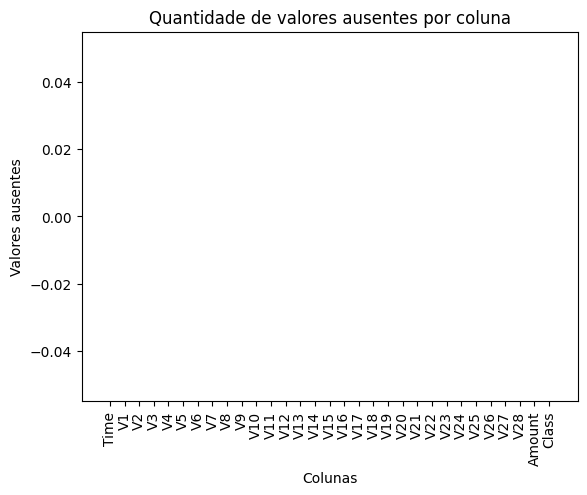

In [ ]:
missing_values = data.isna().sum()

total_missing_values = missing_values.sum()
print(f'O conjunto de dados possui um total de {total_missing_values} valores nulos.')

plt.bar(missing_values.index, missing_values.values)

plt.xticks(rotation=90)
plt.xlabel('Colunas')
plt.ylabel('Valores ausentes')
plt.title('Quantidade de valores ausentes por coluna')
plt.show()


Distribuição das classes:
 0    284315
1       492
Name: Class, dtype: int64


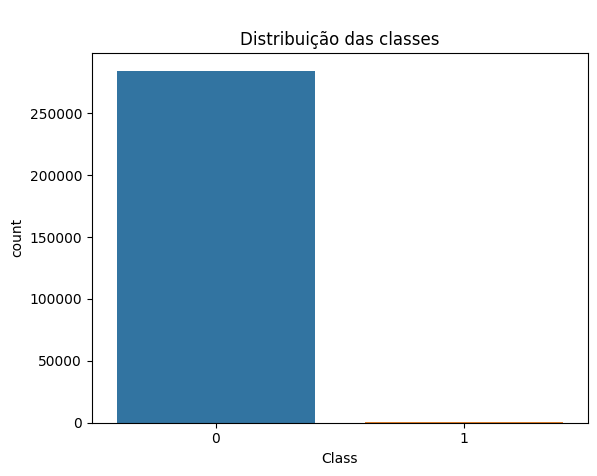

In [ ]:
print("\nDistribuição das classes:\n", data['Class'].value_counts())
plt.title("\nDistribuição das classes")
sns.countplot(x='Class', data=data)
plt.show()

Como podemos ver neste gráfico de contagem, as classes 0 e 1 são altamente desequilibradas

---

### **Analisando as colunas Time e Amount:**
> Como a maioria dos recursos está no formato PCA, exceto Tempo e Valor, teremos que examinar mais profundamente esses dois recursos.


### Vamos tentar visualizar a contagem de transações (em segundos).
> Primeiro faremos isso para todo o conjunto de dados e depois dividiremos entre usuários fraudulentos e usuários não fraudulentos

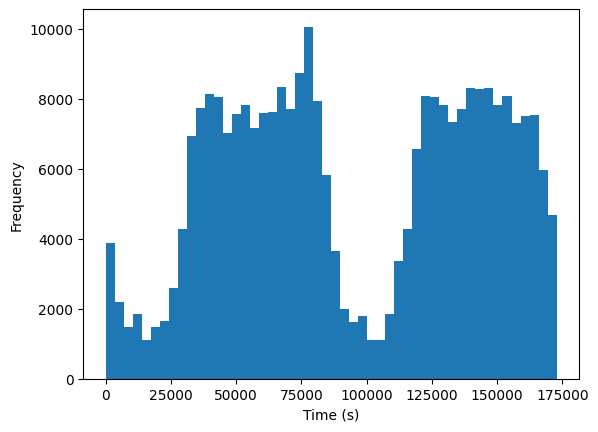

In [ ]:
plt.hist(data['Time'], bins=50)
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.show()


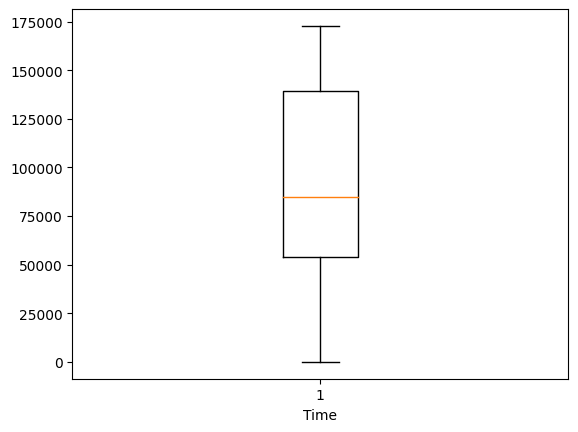

In [ ]:
plt.boxplot(data['Time'])
plt.xlabel('Time')
plt.show()


---

### Agora vamos analisar o valor das transações (coluna Amount)

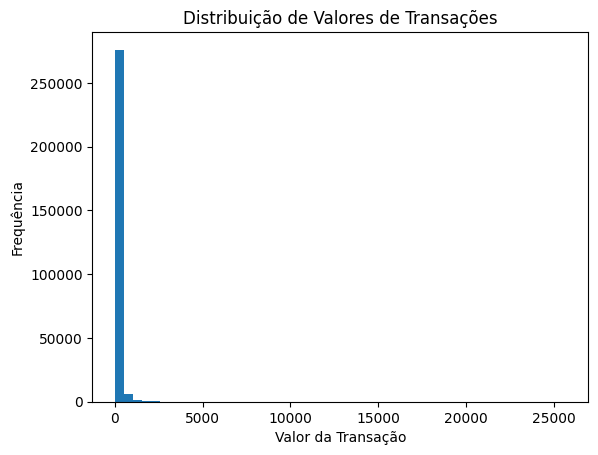

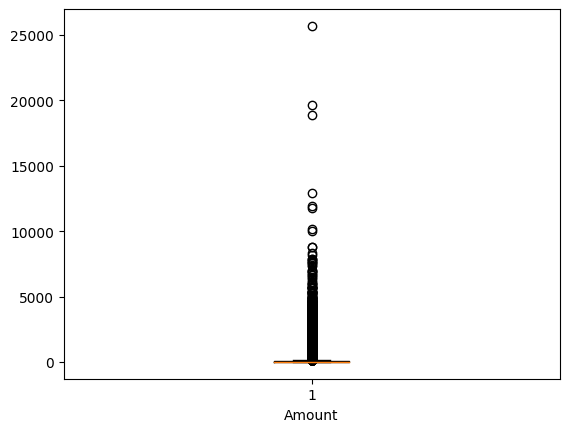

In [ ]:
#criando o histograma
plt.hist(data['Amount'], bins=50)
#adicionando labels e título
plt.xlabel('Valor da Transação')
plt.ylabel('Frequência')
plt.title('Distribuição de Valores de Transações')
#mostrando o gráfico
plt.show()

plt.boxplot(data['Amount'])
plt.xlabel('Amount')
plt.show()


Aqui a gente percebe que a grande maioria das transações possuem um valor baixo, porém há algumas transações isoladas (outliers) com valores muito altos, que podem prejudicar a nossa análise

### Verificando a relação entre o valor e o tempo em que as transações foram realizadas, separando-as em fraudulentas e não fraudulentas

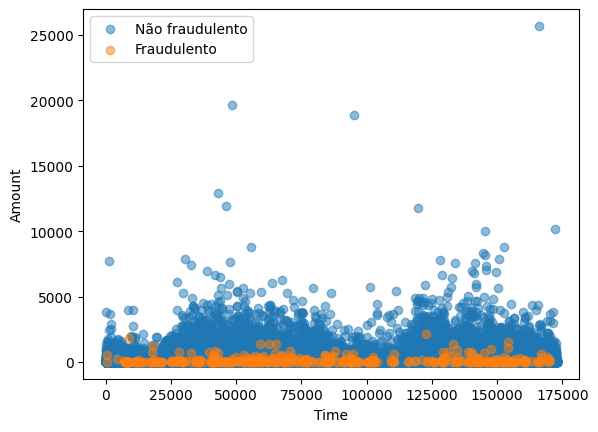

In [ ]:
plt.scatter(data[data['Class']==0]['Time'], data[data['Class']==0]['Amount'], alpha=0.5, label='Não fraudulento')
plt.scatter(data[data['Class']==1]['Time'], data[data['Class']==1]['Amount'], alpha=0.5, label='Fraudulento')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()
plt.show()

---

### Agora vamos analisar a correlação entre as colunas do dataset usando uma matriz de correlações

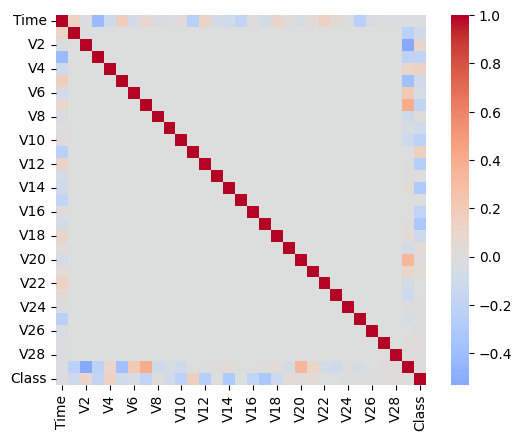

In [ ]:
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, annot=False)
plt.show()

Olhando a matriz de correlações, podemos perceber que as colunas V2, V4, V11 são as que mais influenciam diretamente a nossa variável de interesse Class

## Seleção do Algoritmo de Naive Bayes

* GaussianNB
  >Essa variação assume que os atributos seguem uma distribuição normal (gaussiana). Como as características do nosso conjunto de dados são contínuas e parecem ter uma distribuição próxima à normal após o pré-processamento, o GaussianNB é uma opção adequada.
* MultinomialNB:
  >Essa variação é adequada para dados discretos e é comumente usada em problemas de classificação de texto. Como o nosso conjunto de dados contém características contínuas, o MultinomialNB provavelmente não é a melhor opção.
* BernoulliNB
  >Essa variação é adequada para dados binários. No entanto, nosso conjunto de dados tem características contínuas, então o BernoulliNB também não seria a melhor escolha.

## Experimentos

### Experimento 0: Utilizando a base de dados sem qualquer alteração

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(data.drop('Class', axis=1), data['Class'], test_size=0.2, random_state=42)

# treinar o modelo GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# fazer previsões nos dados de teste
y_pred = gnb.predict(X_test)

# calcular a matriz de confusão
print("Relatório de classificação:\n", classification_report(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

Relatório de classificação:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.15      0.63      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.81      0.62     56962
weighted avg       1.00      0.99      1.00     56962

Acurácia: 0.9930128857835048
[[56502   362]
 [   36    62]]


### Pré-processamento e divisão de dados para os experimentos 1 e 2

#### Normalizando a coluna Amount

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#criar o objeto MinMaxScaler
scaler = MinMaxScaler()

#normalizar a coluna 'Amount'
data['NormalizedAmount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

#remover a coluna 'Amount' original
data.drop(['Amount'], axis=1, inplace=True)

#exibir as primeiras linhas do conjunto de dados
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

#### Divisão dos dados

In [ ]:
from sklearn.model_selection import train_test_split

#dividir o conjunto de dados em atributos (X) e rotulos (y)
X = data.drop('Class', axis=1)
y = data['Class']

#dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

*   80% dos dados usados para treinamento, 20% para teste
*   Função train_test_split do Scikit-learn utilizada para a divisão
*   Parâmetro stratify garante a preservação da proporção das classes em ambos os conjuntos
*   random_state utilizado para garantir a reprodutibilidade da divisão

#### Reamostragem

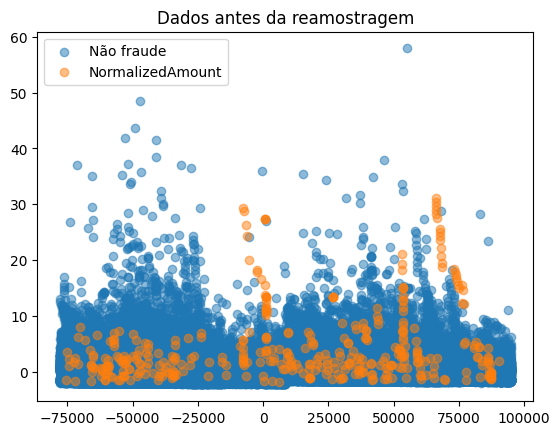

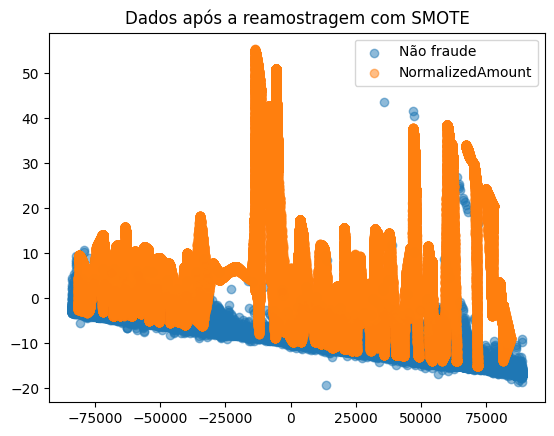

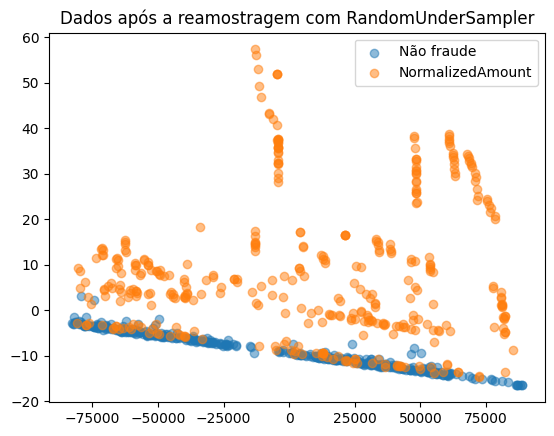

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

def plot_2d(X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Não fraude', alpha=0.5)
    plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='NormalizedAmount', alpha=0.5)
    plt.legend()
    plt.title(title)
    plt.show()

#antes da reamostragem
plot_2d(X_train, y_train, "Dados antes da reamostragem")

#apos a reamostragem com SMOTE
smote = SMOTE()
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)
plot_2d(X_resampled_smote, y_resampled_smote, "Dados após a reamostragem com SMOTE")

#após a reamostragem com RandomUnderSampler
rus = RandomUnderSampler()
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
plot_2d(X_resampled_rus, y_resampled_rus, "Dados após a reamostragem com RandomUnderSampler")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Experimento 1: Reamostragem com Smote

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#criacao do modelo
gnb = GaussianNB()

#treinamento do modelo
gnb.fit(X_train_resampled, y_train_resampled)

#previsoes com o modelo treinado
y_pred = gnb.predict(X_test)

#avaliacao do modelo
print("Relatório de classificação:\n", classification_report(y_test, y_pred))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))


Relatório de classificação:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.13      0.80      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.89      0.61     56962
weighted avg       1.00      0.99      0.99     56962

Matriz de confusão:
 [[56352   512]
 [   20    78]]
Acurácia: 0.9906604402935291


### Experimento 2: selecionando os melhores hiperparâmetros da reamostragem:

**Ajuste de hiperparametros do modelo**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB

#configurar o k-fold
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

#definir os hiperparâmetros e o espaço de busca
params = {'var_smoothing': [1e-12, 1e-11, 1e-10, 1e-9]}

#criar o modelo Gaussian Naive Bayes
gnb = GaussianNB()

#configurar o GridSearchCV com k-fold
grid_search = GridSearchCV(gnb, params, scoring='f1', cv=kfold)

#ajustar o GridSearchCV aos dados balanceados
grid_search.fit(X_train_resampled, y_train_resampled)

print("Melhores hiperparâmetros: ", grid_search.best_params_)

Melhores hiperparâmetros:  {'var_smoothing': 1e-12}


**Treinar e avaliar o modelo usando os hiperparâmetros encontrados no kfold**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Criar o modelo Gaussian Naive Bayes com os melhores hiperparâmetros
gnb = GaussianNB(var_smoothing=1e-12)

# Treinar o modelo
gnb.fit(X_train_resampled, y_train_resampled)

# Fazer previsões no conjunto de testes
y_pred = gnb.predict(X_test)

# Avaliar o modelo
print("Relatório de classificação:\n", classification_report(y_test, y_pred))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))

Relatório de classificação:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.88      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.93      0.54     56962
weighted avg       1.00      0.97      0.99     56962

Matriz de confusão:
 [[55367  1497]
 [   12    86]]
Acurácia: 0.9735086548927355


### Experimento 3: subamostra balanceada

**Testes com subamostras**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

data = pd.read_csv('/content/drive/MyDrive/ET586_seminario/dataset/creditcard.csv')

fraud = data[data['Class'] == 1]
non_fraud = data[data['Class'] == 0].sample(len(fraud))

subsample = pd.concat([fraud, non_fraud]).sample(frac=1, random_state=42)

# Dividir em conjuntos de treino e teste
X = subsample.drop('Class', axis=1)
y = subsample['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar o SMOTE (se necessário)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Normalizar os recursos usando StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinar e testar o modelo Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

# Avaliar o desempenho do modelo
print("Relatório de classificação:\n", classification_report(y_test, y_pred))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))


Relatório de classificação:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91        87
           1       0.97      0.87      0.92       110

    accuracy                           0.91       197
   macro avg       0.91      0.92      0.91       197
weighted avg       0.92      0.91      0.91       197

Matriz de confusão:
 [[84  3]
 [14 96]]
Acurácia: 0.9137055837563451


Mantendo a classe "fraudes" e selecionando "não-fraudes" aleatoriamente para criar o conjunto de subamostra

Esse teste tenta equilibrar o conjunto de dados para conter um número igual de transações fraudulentas e não fraudulentas. Isso ajuda a evitar problemas comuns associados a conjuntos de dados desequilibrados, como um desempenho de classificação ruim para a classe minoritária.